## A notebook to get the curlTau input field

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import requests
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

import dask.array as da
from dask.diagnostics import ProgressBar

In [2]:
experiment = 'ssp585'

In [3]:
if experiment == 'control':
    path='/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/'
    ds_grid=xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ocean_monthly.static.nc')
elif experiment == 'historical':
    path='/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/'
    ds_grid=xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ocean_monthly.static.nc')
elif experiment == 'ssp585':
    path='/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/'
    ds_grid=xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ocean_monthly.static.nc')

dsShortGrid=ds_grid.isel(xq=np.arange(1,1441)).isel(yq=np.arange(1,1081))

In [4]:
variables_yh_xq=['taux_bot', 'taux']
variables_yq_xh=['tauy_bot', 'tauy']
#variables_yh_xh=['pbo', 'wfo', 'col_height']

# list with all the variable field names
all_variable_fields = variables_yh_xq + variables_yq_xh #+ variables_yh_xh

In [5]:
test=glob.glob(path + 'ocean_monthly.*.intz_rvxv_2d.nc')

if experiment == 'control':
    year_name_start_idx, year_name_end_idx = 161, 174
elif experiment == 'historical':
    year_name_start_idx, year_name_end_idx = 159, 172
elif experiment == 'ssp585':
    year_name_start_idx, year_name_end_idx = 155, 168

one=test[0]
times=[one[year_name_start_idx:year_name_end_idx]]

for tt in np.arange(1,len(test)): 
    one=test[tt]
    times=times+[one[year_name_start_idx:year_name_end_idx]]

times = sorted(times)
    
if experiment == 'control':
    pass
elif experiment == 'historical':
    times = times[-5:]
elif experiment == 'ssp585':
    #times = times[-4:]
    times = times[-12:-8]

times

['204001-204412', '204501-204912', '205001-205412', '205501-205912']

In [6]:
datasets = []

if experiment == 'control':
    pass
elif experiment == 'historical':
    start_yr, end_yr = '1992', '2013'
elif experiment == 'ssp585':
    pass

for var in all_variable_fields:
    files = [f'{path}/ocean_monthly.{time}.{var}.nc' for time in times]
    
    '''
    for file in files:
        print('Opening')
        tmp = xr.open_mfdataset(file)
    '''
    
    print('Gathering dataset...')
    ds = xr.open_mfdataset(files, chunks={"time": 10}, parallel=True)
    with ProgressBar():
        ds = ds.compute()
        
    datasets.append(ds)

datasets.append(ds_grid)

print('Merging datasets...')
if experiment == 'control':
    full_ds = xr.merge(datasets).compute()
elif experiment == 'historical':
    full_ds = xr.merge(datasets).sel(time=slice(start_yr, end_yr)).compute()
elif experiment == 'ssp585':
    full_ds = xr.merge(datasets).compute()
    
full_ds

Gathering dataset...
[########################################] | 100% Completed | 16.23 ss
Gathering dataset...
[########################################] | 100% Completed | 15.21 ss
Gathering dataset...
[########################################] | 100% Completed | 15.83 ss
Gathering dataset...
[########################################] | 100% Completed | 16.19 ss
Merging datasets...


<xarray.Dataset>
Dimensions:       (time: 240, nv: 2, yh: 1080, xq: 1441, yq: 1081, xh: 1440)
Coordinates:
  * nv            (nv) float64 1.0 2.0
  * time          (time) object 2040-01-16 12:00:00 ... 2059-12-16 12:00:00
  * xq            (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yq            (yq) float64 -80.43 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables: (12/34)
    average_DT    (time) timedelta64[ns] 31 days 28 days ... 30 days 31 days
    average_T1    (time) datetime64[ns] 2039-11-16 2039-12-17 ... 2059-10-11
    average_T2    (time) datetime64[ns] 2039-12-17 2040-01-14 ... 2059-11-11
    taux_bot      (time, yh, xq) float64 nan nan nan nan nan ... nan nan nan nan
    time_bnds     (time, nv) object 2040-01-01 00:00:00 ... 2060-01-01 00:00:00
    taux          (time, yh, xq) float64 nan nan nan nan nan ... nan nan nan nan
    ...            ...
    hfgeou        (yh, xh) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sftof         (yh, xh) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wet           (yh, xh) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wet_c         (yq, xq) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wet_u         (yh, xq) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wet_v         (yq, xh) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    filename:          ocean_monthly.204001-204412.taux_bot.nc
    title:             CM4_ssp585_c192_OM4p25
    associated_files:  areacello: 20400101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [7]:
dsShort=full_ds.isel(xq=np.arange(1,1441)).isel(yq=np.arange(1,1081))
ds=dsShort

# Create grid
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

# Interpolate depth, beta
# These lines of code were included in the original notebook, but they are not necessary
# for simply computing curlTau
'''
OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

depth_u = grid.interp(ds['deptho'] * ds['areacello'], 'X',  boundary='fill')  / ds['areacello_cu']
depth_v = grid.interp(ds['deptho'] * ds['areacello'], 'Y',  boundary='fill') / ds['areacello_cv']
depth_q = grid.interp(depth_u * ds['areacello_cu'], 'Y',  boundary='fill') / ds['areacello_bu']

colh_u = grid.interp(ds['col_height'] * ds['areacello'], 'X',  boundary='fill') / ds['areacello_cu']
colh_v = grid.interp(ds['col_height'] * ds['areacello'], 'Y',  boundary='fill') / ds['areacello_cv']

beta_v = 2*OMEGA*np.cos(ds.geolat_v * np.pi /180.)/RAD_EARTH
beta_q = 2*OMEGA*np.cos(ds.geolat_c * np.pi /180.)/RAD_EARTH
'''

# Compute terms in vorticity budget
rho_0 = 1035.
BPT = xr.Dataset()

print('Computing curlTau_s...')
Curl_taus = ( - grid.diff((ds['taux'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff((ds['tauy'])* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
Curl_taus = Curl_taus / (rho_0 )
BPT['Curl_taus'] = Curl_taus

print('Computing curlTau_b...')
Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
Curl_taub = Curl_taub / (rho_0 )
BPT['Curl_taub'] = Curl_taub

ds_save = xr.Dataset()

ds_save['Curl_taus'] =  BPT['Curl_taus']
ds_save['Curl_taus'].attrs['units'] = "m/s^2"
ds_save['Curl_taus'].attrs['standard_name'] = "Curl of Surface Wind Stress / rho_0"

ds_save['Curl_taub'] =  BPT['Curl_taub']
ds_save['Curl_taub'].attrs['units'] = "m/s^2"
ds_save['Curl_taub'].attrs['standard_name'] = "- Curl of bottom boundary stress / rho_0"

Computing curlTau_s...
Computing curlTau_b...


In [8]:
ds_save_time_mean = ds_save.mean('time')
ds_save_time_mean

<xarray.Dataset>
Dimensions:    (xq: 1440, yq: 1080)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    Curl_taus  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taub  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [9]:
ds_save_time_mean['Curl_taus'].to_netcdf(f'Data_Step2/{experiment}_2040_2059/curlTau.nc')

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

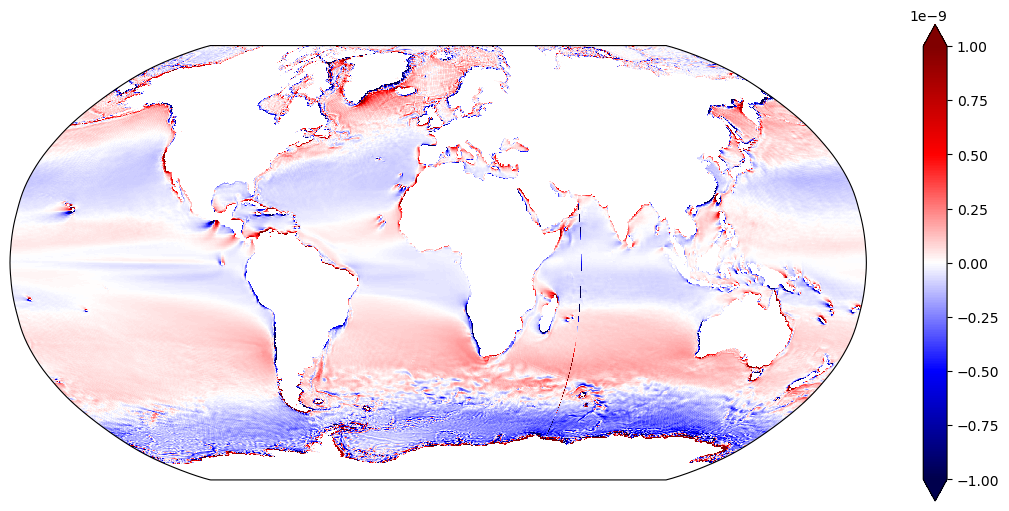

In [11]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.Robinson()}, figsize=(10,5), constrained_layout=True)
to_plot = ds_save_time_mean['Curl_taus'] #+ ds_save_time_mean['Curl_taub']
to_plot.plot(ax=axes, transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-1e-9, vmax=1e-9)

#gl = axes.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
#gl.top_labels = False

plt.show()